In [1]:
from PIL import Image,ImageDraw
import random
import pandas as pd
import tensorflow as tf
import glob
import numpy as np
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
path_train = './rectangles/train/'
#генерируем обучающую выборку путем вращения прямоугольника по/против часовой стрелки
img = Image.new('L', (128, 128), "white") #создание изображения 128*128
lineDrawer = ImageDraw.Draw(img)
lineDrawer.rectangle((15,118,113,10))  #изображение прямоугольника 
img.save(path_train + "img.png", 'PNG')

In [522]:
path_train = './rectangles/train/'
for filename in glob.glob(path_train + '*.png'): 
    img=Image.open(filename)

In [523]:
#масштабирование
img = np.array(img)
img = np.expand_dims(img, -1)
img = np.asarray(img)/255.
img = np.expand_dims(img, 0)

In [527]:
#функция поворота входного изображения
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    angles = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    X = tf.placeholder(tf.float32, shape = (None, 128, 128, 1))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            angles.append(int(degrees_angle))
            angles_arr = [degrees_angle] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: angles_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate, angles

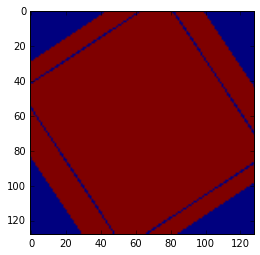

In [557]:
a = random.randint(0,90)
b = random.randint(0,90)
rotated_imgs = rotate_images(img, a, b, 10)
plt.imshow(rotated_imgs[0][0].reshape(128,128))

In [602]:
X = tf.placeholder(tf.float32, shape=[None,128,128,1])
Y = tf.placeholder(tf.float32, shape=[None,90])
#слои свертки и пулинга
conv1 = tf.layers.conv2d(inputs=X, filters=8, kernel_size=[2,2], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=[2,2],padding="same",activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#полносвязный слой
flattened = tf.contrib.layers.flatten(pool2)

w1 = tf.Variable(tf.random_normal(shape=[4096, 90])) 
b1 = tf.Variable(tf.zeros(shape = [90]))
out =  tf.nn.softmax(tf.add(tf.matmul(flattened,w1),b1))

cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(out), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [603]:
correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [580]:
flattened #размер вектора

<tf.Tensor 'Flatten_43/Reshape:0' shape=(?, 4096) dtype=float32>

In [608]:
height = 128
width = 128
training_epochs = 500

In [609]:
#Инициализация
init = tf.global_variables_initializer()
#Обучение
display_step = 1
sss = tf.Session()
sss.run(init)

for epoch in range(training_epochs):
    a = random.randint(0,90)
    b = random.randint(0,90)
    rotated_imgs = rotate_images(img, a, b, 20)
    rotated_values = np.array(rotated_imgs[1]).astype(int)
    rotated_values = sss.run(tf.one_hot(rotated_values, 90))
    if epoch % 10 == 0:
        rotated_imgs = rotate_images(img, a, b, 20)
        rotated_values = np.array(rotated_imgs[1]).astype(int)
        rotated_values = sss.run(tf.one_hot(rotated_values, 90))
        train_accuracy = sss.run(accuracy ,feed_dict={X: rotated_imgs[0], Y:rotated_values})
        loss = sss.run(cross_entropy, {X: rotated_imgs[0], Y: rotated_values})
        print('step %d, training accuracy %g, loss= %g' % (epoch, train_accuracy, loss))
        
    sss.run(train_step, feed_dict={X: rotated_imgs[0], Y: rotated_values})

print("Optimization Finished!")

step 0, training accuracy 0, loss= 21.248
step 10, training accuracy 0, loss= 20.9718
step 20, training accuracy 0, loss= 20.45
step 30, training accuracy 0, loss= 19.2311
step 40, training accuracy 0.05, loss= 17.0898
step 50, training accuracy 0, loss= 19.9381
step 60, training accuracy 0.05, loss= 16.2816
step 70, training accuracy 0, loss= 14.7684
step 80, training accuracy 0, loss= 12.463
step 90, training accuracy 0, loss= 15.624
step 100, training accuracy 0, loss= 13.1912
step 110, training accuracy 0, loss= 12.9897
step 120, training accuracy 0, loss= 15.844
step 130, training accuracy 0, loss= 8.18393
step 140, training accuracy 0, loss= 10.4959
step 150, training accuracy 0, loss= 13.1394
step 160, training accuracy 0, loss= 10.5447
step 170, training accuracy 0, loss= 7.71624
step 180, training accuracy 0.05, loss= 11.4418
step 190, training accuracy 0, loss= 9.46069
step 200, training accuracy 0, loss= 11.0296
step 210, training accuracy 0.05, loss= 9.78768
step 220, train

In [610]:
#Тест по 10 повернутым изображениям
a = random.randint(0,90)
b = random.randint(0,90)
rotated_imgs = rotate_images(img, a, b, 10)
res = sss.run(out, feed_dict={X: rotated_imgs[0]})
print(sss.run(tf.argmax(res,1)),rotated_imgs[1])

[78 78 78 77 78 78 78 78 37 42] [15, 16, 18, 19, 21, 22, 24, 25, 27, 29]
